# Metrics, validation strategies and baselines

В данном jupyter notebook рассматриваются примеры того, какие схемы валидации и метрики используются в рекомендательных системах.
Также построим простые модели (бейзлайны) на данных МТС Библиотеки. 

* [Preprocessing](#preprocessing)
* [General remarks](#general-remarks)
* [Metrics](#metrics)
    * [Regression](#regression)
    * [Classification](#classification)
    * [Ranking](#ranking)
* [Validation strategies](#validation)
* [Baselines](#baselines)

In [ ]:
import os
import numpy as np 
import pandas as pd 
from itertools import islice, cycle
from more_itertools import pairwise

print('Dataset:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="preprocessing"></a>
# Preprocessing

Загрузим наши данные, теперь уже с фичами, и применим знания из [pandas-scipy-for-recsys](https://www.kaggle.com/sharthz23/pandas-scipy-for-recsys)

In [ ]:
df = pd.read_csv('../input/mts-library/interactions.csv')
df_users = pd.read_csv('../input/mts-library/users.csv')
df_items = pd.read_csv('../input/mts-library/items.csv')

## Interactions

In [ ]:
df.info()

In [ ]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [ ]:
duplicates = df.duplicated(subset=['user_id', 'item_id'], keep=False)
df_duplicates = df[duplicates].sort_values(by=['user_id', 'start_date'])
df = df[~duplicates]

In [ ]:
df_duplicates = df_duplicates.groupby(['user_id', 'item_id']).agg({
    'progress': 'max',
    'rating': 'max',
    'start_date': 'min'
})
df = df.append(df_duplicates.reset_index(), ignore_index=True)

In [ ]:
df['progress'] = df['progress'].astype(np.int8)
df['rating'] = df['rating'].astype(pd.SparseDtype(np.float32, np.nan))

In [ ]:
df.info()

In [ ]:
df.to_pickle('interactions_preprocessed.pickle')

In [ ]:
!ls -lah

## Users

In [ ]:
df_users.head()

In [ ]:
df_users.info()

In [ ]:
df_users.nunique()

In [ ]:
df_users['age'] = df_users['age'].astype('category')
df_users['sex'] = df_users['sex'].astype(pd.SparseDtype(np.float32, np.nan))

In [ ]:
df_users.info()

In [ ]:
interaction_users = df['user_id'].unique()

common_users = len(np.intersect1d(interaction_users, df_users['user_id']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, df_users['user_id']))
users_only_features = len(np.setdiff1d(df_users['user_id'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features
print(f'Кол-во пользователей - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users * 100:.2f}%)')

In [ ]:
df_users.to_pickle('users_preprocessed.pickle')

In [ ]:
!ls -lah

## Items

In [ ]:
df_items.head()

In [ ]:
df_items.info(memory_usage='full')

In [ ]:
def num_bytes_format(num_bytes, float_prec=4):
    units = ['bytes', 'Kb', 'Mb', 'Gb', 'Tb', 'Pb', 'Eb']
    for unit in units[:-1]:
        if abs(num_bytes) < 1000:
            return f'{num_bytes:.{float_prec}f} {unit}'
        num_bytes /= 1000
    return f'{num_bytes:.4f} {units[-1]}'

In [ ]:
num_bytes = df_items.memory_usage(deep=True).sum()
num_bytes_format(num_bytes)

In [ ]:
df_items.nunique()

Почему колонка `year` типа `object`, а не `int`?

In [ ]:
df_items['year'].value_counts().tail(25)

In [ ]:
df_items[df_items['year'] == '1898, 1897, 1901']

In [ ]:
for col in ['genres', 'authors', 'year']:
    df_items[col] = df_items[col].astype('category')

In [ ]:
df_items.info(memory_usage='full')

In [ ]:
num_bytes = df_items.memory_usage(deep=True).sum()
num_bytes_format(num_bytes)

In [ ]:
interaction_items = df['item_id'].unique()

common_items = len(np.intersect1d(interaction_items, df_items['id']))
items_only_in_interaction = len(np.setdiff1d(interaction_items, df_items['id']))
items_only_features = len(np.setdiff1d(df_items['id'], interaction_items))
total_items = common_items + items_only_in_interaction + items_only_features
print(f'Кол-во книг - {total_items}')
print(f'Кол-во книг c взаимодействиями и фичами - {common_items} ({common_items / total_items * 100:.2f}%)')
print(f'Кол-во книг только c взаимодействиями - {items_only_in_interaction} ({items_only_in_interaction / total_items * 100:.2f}%)')
print(f'Кол-во книг только c фичами - {items_only_features} ({items_only_features / total_items * 100:.2f}%)')

In [ ]:
df_items.to_pickle('items_preprocessed.pickle')

In [ ]:
!ls -lah

<a id="general-marks"></a>
# General marks

Основная цель валидации - оценить качество модели перед внедрением в "продакшен" или сабмитом в соревновании. Отсюда вытекает одно из самых важных требование к процессу валидации - *схема должна максимально точно воспроизводить условия, в которых модель будет использоваться.* Это касается как продакшена, так и соревнований, причем не только в рекомендательных системах, а в любой задаче машинного обучения. **Правильная валидация - ключ к успеху** :)

Ключевые вопросы, на которые надо ответить:
* Что хотим от модели?
    * Предсказанное значение для пары пользователь-объект (рейтинг или вероятность)
    * Ранжирование объектов для пользователя (топ фильмов)
* Как будет использоваться модель? 
    * Рекомендации будут считаться батчами раз в период (1 раз в день)
    * Онлайн-рекомендации
    * Связь бизнес-метрик с оффлайн-метриками
* Какие технические ограничения?
    * По времени построения как системы в целом, так и отдельных рекомендаций (чем меньше "железа", тем проще должна быть модель)
    * Какие данные будут доступны в онлайн-режиме
* Как есть особенности у задачи?
    * Рекомендуем ли для пользователя объекты, с которым он уже взаимодействовал (для фильмов или книг - скорее всего нет, для продуктового ритейла - может быть и да)
    * Cold-start - как много появится пользователей или объектов, для которых не известная история по взаимодействиям
    * Как много взаимодействий по пользователям есть в данных

<a id="metrics"></a>
# Metrics

Как это водится в машинном обучении, для подсчета метрик нам нужно два массива: правильный ответы и предсказанные ответы.
И если в классическом машинном обучении это действительно два массива, то в рекомендательных системах нам нужна структура, которая в качевстве ключа или индекса будет содержать пары пользователь-объект.

В качестве такой структуры вполне подойдет уже известный pandas.DataFrame. 
Правильные метки (true) мы можем представить в виде dataframe со следующими столбцами:
* user_id - ID пользователя
* item_id - ID объекта
* value - оценка взаимодействия (опционально, может и не быть, если мы, например, за взаимодействие берем просто клик или факт покупки)

Соответственно, рекомендации/предсказания (recs) в следующем:
* user_id - ID пользователя
* item_id - ID объекта
* value - предсказанная оценка взаимодействия 
    * Численная оценка, например рейтинг
    * Позиция, если мы ранжируем контент
    
Для подсчета метрик мы можем объединить эти два датафрема по `(user_id, item_id)`. В качестве метода объединения можно использовать методы join/merge из pandas.DataFrame.

<a id="regression"></a>
## Regression

Эти метрики оценивают качество предсказанных численных оценок. Примеры метрик:
* Mean Squared Error - среднеквадратичная ошибка
* Root Mean Squared Error - корень из среднеквадратичной ошибки
* Mean Absolute Error - средний ошибка по модулю
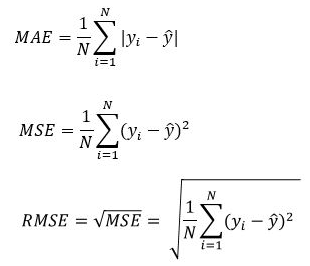
Эти метрики показываются, как хорошо модель "восстанавливает" какие-то численные оценки, но не то, насколько хороши рекомендации

In [ ]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
    'value':   [4,                    5,                    3,            5]
})
df_true

In [ ]:
df_recs = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
    'value':   [3.28,                 3.5,                  4.06,           4.73]
})
df_recs

In [ ]:
df_true = df_true.set_index(['user_id', 'item_id'])
df_recs = df_recs.set_index(['user_id', 'item_id'])

df_merged = df_true.join(df_recs, how='left', lsuffix='_true', rsuffix='_recs')
df_merged

In [ ]:
df_merged['MAE'] = (df_merged['value_true'] - df_merged['value_recs']).abs()
df_merged['MSE'] = (df_merged['value_true'] - df_merged['value_recs']) ** 2
df_merged

In [ ]:
print(f"MAE  - {df_merged['MAE'].mean():.4f}")
print(f"MSE  - {df_merged['MSE'].mean():.4f}")
print(f"RMSE - {np.sqrt(df_merged['MSE'].mean()):.4f}")

<a id="classification"></a>
## Classification

Эти метрики оценивают качество топ-N рекомендаций. В рекомендательные системы напрямую перекочевали из методов оценки качества бинарной классификации.
Все считается на основе 4 базовых случаев:
* True positive  (TP) - модель рекомендовала объект, с которым пользователь провзаимодействовал
* False positive (FP) - модель рекомендовала объект, с которым пользователь не провзаимодействовал
* True negative  (TN) - модель не рекомендовала объект, с которым пользователь не провзаимодействовал
* False negative (FN) - модель не рекомендовала объект, с которым пользователь провзаимодействовал

Что из этого всего важней? В первую очередь это True positive. Мы хотим строить наиболее релевантные рекомендации для пользователя. 
Во вторую очередь это False negative, опять же потому, что мы не хотим, чтобы модель "теряла" релевантные рекомендации.

А что с FP и TN? На самом деле, эти величины не показательны. Они обычно очень больше, так как пользователи взаимодействуют с очень малым количество объектов относительно общего числа объектов.
И практика показывает, что этими значениями можно пренебречь.

Для измерения доли TP и FN применяются следующие метрики:
* **Precision@K** - доля релевантных рекомендаций среди всех рекомендаций
    * Формула - `TP / (TP + FP)`
    * Можно заметить, что под positives мы понимаем рекомендованные объекты, то есть наш топ-К, значит `TP + FP = K`
    * Итоговая формула - `TP / K`
    * Считаем по каждому пользователю и для некторых К
    * Усредняем по всем пользователя
* **Recall@K** - доля релевантных рекомендаций среди всех релевантных объектов
    * Формула - `TP / (TP + FN)`
    * `TP + FN` это количество известных релевантых объектов для пользователя
    * Считаем по каждому пользователю и для некторых К
    * Усредняем по всем пользователя

Это основные метрики, но на основе TP, FP, TN, FN можно посчитать все что угодно :)
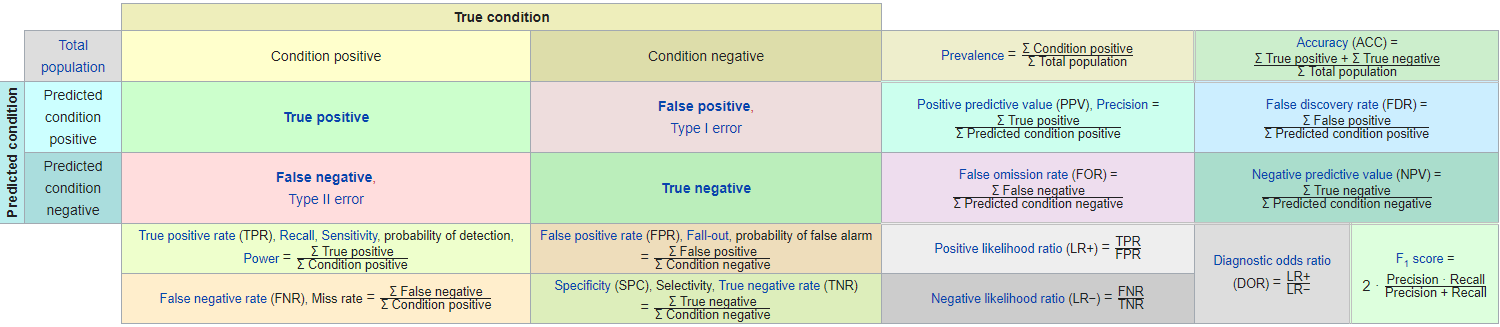
Источник - [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [ ]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
})
df_true

In [ ]:
df_recs = pd.DataFrame({
    'user_id': [
        'Аня', 'Аня', 'Аня', 
        'Боря', 'Боря', 'Боря', 
        'Вася', 'Вася', 'Вася',
    ],
    'item_id': [
        'Отверженные', 'Двенадцать стульев', 'Герои нашего времени', 
        '451° по Фаренгейту', '1984', 'О дивный новый мир',
        'Десять негритят', 'Искра жизни', 'Зеленая миля', 
    ],
    'rank': [
        1, 2, 3,
        1, 2, 3,
        1, 2, 3,
    ]
})
df_recs

In [ ]:
df_merged = df_true.set_index(['user_id', 'item_id']).join(df_recs.set_index(['user_id', 'item_id']), how='left')
df_merged

Вначале посчитаем метрик для топ-2 (т.е. К = 2). Алгоритм следующий:
* Релевантные объекты, которые не были рекомендованы игнорируем (NaN)
* Определяем, какие релеватные рекомендации попали в топ-2 (hit)
    * True positive для каждого пользователя
* Делим TP на K  
* Считаем Precision@K для каждого пользователя как сумму его TP/K
* Все Precision@K усредняем

In [ ]:
df_merged['hit@2'] = df_merged['rank'] <= 2
df_merged

In [ ]:
df_merged['hit@2/2'] = df_merged['hit@2'] / 2
df_merged

In [ ]:
df_prec2 = df_merged.groupby(level=0)['hit@2/2'].sum()
df_prec2

In [ ]:
print(f'Precision@2 - {df_prec2.mean()}')

Но вообще шаг с группировкой по пользователям для Precision@K не нужен

In [ ]:
df_merged['hit@2/2'].sum() / df_merged.index.get_level_values('user_id').nunique()

In [ ]:
users_count = df_merged.index.get_level_values('user_id').nunique()
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    df_merged[hit_k] = df_merged['rank'] <= k
    print(f'Precision@{k} = {(df_merged[hit_k] / k).sum() / users_count:.4f}')

C Recall@K похожая история, нам также нужно получить hit@K, но делить уже будем на количество релевантных объектов у пользователя

In [ ]:
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)
df_merged

In [ ]:
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    # Уже посчитано
    # df_merged[hit_k] = df_merged['rank'] <= k  
    print(f"Recall@{k} = {(df_merged[hit_k] / df_merged['users_item_count']).sum() / users_count:.4f}")

Precision@K и Recall@K неплохие метрики, чтобы оценить качество рекомендаций, но они учитывают только "попадания" (hits, true positives). 
Но на самом деле нам важно насколько высоко по позициям находятся эти самые попадания. 

Простой пример, пусть две модели рекомендаций для одного пользователя получили такие hit@3 на тесте:
* model1 - 1, 0, 0, 1
* model2 - 1, 0, 1, 0

Precision@4 для них будет одинаковый - 0.5, хотя model2 немного лучше, так как 2-ое попадание находится выше, чем у model1

<a id="ranking"></a>
## Ranking

Эти метрики оценивают качество топ-N рекомендаций c учетом рангов/позиций. Основная идея - оценить "попадания" с весом, зависящим от позиции (обычно это обратная пропорциальная зависимость, то есть чем больше позиция, тем меньше вес).
Основные метрики следующие:

**Mean Reciprocal Rank**
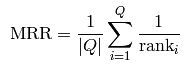
Где Q - это query или наш пользователь, а rank_i - позиция первой релевантной рекомендации

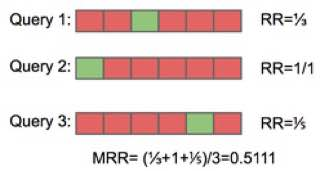

**Mean Average Precision**
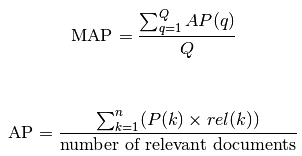
То есть MAP - это усреднение AveragePrecision по всем пользователям. 
А AveragePrecision в свою очередь, это средний Precision@K по релевантным объектам одного пользователя

In [ ]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
})
df_true 

In [ ]:
df_recs = pd.DataFrame({
    'user_id': [
        'Аня', 'Аня', 'Аня', 
        'Боря', 'Боря', 'Боря', 
        'Вася', 'Вася', 'Вася',
    ],
    'item_id': [
        'Отверженные', 'Двенадцать стульев', 'Герои нашего времени', 
        '451° по Фаренгейту', '1984', 'О дивный новый мир',
        'Десять негритят', 'Рита Хейуорт и спасение из Шоушенка', 'Зеленая миля', 
    ],
    'rank': [
        1, 2, 3,
        1, 2, 3,
        1, 2, 3,
    ]
})
df_recs

In [ ]:
df_merged = df_true.set_index(['user_id', 'item_id']).join(df_recs.set_index(['user_id', 'item_id']), how='left')
df_merged = df_merged.sort_values(by=['user_id', 'rank'])
df_merged

In [ ]:
df_merged['reciprocal_rank'] = 1 / df_merged['rank']
df_merged

In [ ]:
mrr = df_merged.groupby(level='user_id')['reciprocal_rank'].max()
mrr

In [ ]:
print(f"MRR = {mrr.fillna(0).mean()}")

In [ ]:
df_merged['cumulative_rank'] = df_merged.groupby(level='user_id').cumcount() + 1
df_merged['cumulative_rank'] = df_merged['cumulative_rank'] / df_merged['rank']
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)
df_merged

In [ ]:
users_count = df_merged.index.get_level_values('user_id').nunique()
map3 = (df_merged["cumulative_rank"] / df_merged["users_item_count"]).sum() / users_count
print(f"MAP@3 = {map3}")

<a id="validation"></a>
# Validation

Для получения train/test (или train/validation/test) глобально есть два подхода:
* Случайное разбиение
    * По всем взаимодействиям
    * По пользователю или объекту
* Разбиение по времени

## Случайное разбиение

Обычно применяется схема Leave-one-out или Leave-P-out. Идея проста, давайте для одного (Leave-one-out) или нескольких (Leave-P-out) пользователей, для которых есть больше 2 взаимодействий, оставим одно взаимодействие в качестве теста.
На практике такой метод редко применяется по двум причинам:
* Дорогостоящая схема проверки, на боевых данных такое считаться будет долго
* Часто в данных присутствует временная зависимость

Реализовать можно через pandas.DataFrame.sample

## Разбиение по времени

Чаще всего встречается на практике. Обычно выбирается размер test по времени и период дат для разделения на train/test.

Например: test - 1 день, период для тестирования 7 дней.

Для наших данных по МТС Библиотеке выбрем 7 последних дней и будем тестировать на них последовательно.

In [ ]:
test_dates = df['start_date'].unique()[-7:]
test_dates

Соберем из этих дат последовательные пары. Первая дата будет использоваться для ограничения на train, и обе даты будут использоваться для получения test

In [ ]:
test_dates = list(pairwise(test_dates))
test_dates

In [ ]:
split_dates = test_dates[0]
train = df[df['start_date'] < split_dates[0]]
test = df[(df['start_date'] >= split_dates[0]) & (df['start_date'] < split_dates[1])]
test = test[(test['rating'] >= 4) | (test['rating'].isnull())]
split_dates, train.shape, test.shape

<a id="baselines"></a>
# Baselines

Самым популярным бейзлайном является просто построение популярного :)
Гиперпараметром такой модели может быть например окно, за которое мы считаем популярное.

Модель можно расширять засчет учета фичей, чтобы считать популярное в рамках каких-то групп.

Но на самом деле бейзлайны в первую очередь зависят от типа данных. В некоторых случаях это могут быть простые модели (или даже бизнес-правила), которые просто учитывают контекст задачи.

In [ ]:
class PopularRecommender():
    def __init__(self, max_K=100, days=30, item_column='item_id', dt_column='date'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df, ):
        min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.values
    
    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [ ]:
pop_model = PopularRecommender(days=7, dt_column='start_date')
pop_model.fit(train)

In [ ]:
top10_recs = pop_model.recommend()
top10_recs

In [ ]:
item_titles = pd.Series(df_items['title'].values, index=df_items['id']).to_dict()
item_titles[128115]

In [ ]:
list(map(item_titles.get, top10_recs))

In [ ]:
recs = pd.DataFrame({'user_id': test['user_id'].unique()})
top_N = 10
recs['item_id'] = pop_model.recommend(recs['user_id'], N=top_N)
recs.head()

In [ ]:
recs = recs.explode('item_id')
recs.head(top_N + 2)

In [ ]:
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

In [ ]:
test_recs = test.set_index(['user_id', 'item_id']).join(recs.set_index(['user_id', 'item_id']))
test_recs = test_recs.sort_values(by=['user_id', 'rank'])
test_recs.tail()

In [ ]:
test_recs['users_item_count'] = test_recs.groupby(level='user_id', sort=False)['rank'].transform(np.size)
test_recs['reciprocal_rank'] = 1 / test_recs['rank']
test_recs['reciprocal_rank'] = test_recs['reciprocal_rank'].fillna(0)
test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
test_recs.tail()

In [ ]:
test_recs[test_recs['rank'].notnull()].head()

In [ ]:
print(f'Метрик по test ({str(split_dates[0])[:10]}, {str(split_dates[1])[:10]})')
users_count = test_recs.index.get_level_values('user_id').nunique()
for k in range(1, top_N + 1):
    hit_k = f'hit@{k}'
    test_recs[hit_k] = test_recs['rank'] <= k
    print(f'Precision@{k} = {(test_recs[hit_k] / k).sum() / users_count:.4f}')
    print(f"Recall@{k} = {(test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count:.4f}")

mapN = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
print(f"MAP@{top_N} = {mapN}")

mrr = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
print(f"MRR = {mrr}")

### В качестве домашнего задания:
* Попробуйте посчитать теперь метрик по всем фолдам в test_dates и оценить mean, std во времени. Стабильна ли модель во времени?
* Постройте популярное по группам: возрастам пользователей или жанрам книг. Метрики стали лучше?